# Squeezing out Perfomance from your Tensorflow DL Networks

`@author:`[Anindya Saha](https://www.linkedin.com/in/anindyacs/)  
`mail.anindya@gmail.com`

## Cassava Leaf Disease Classification - TF2 Keras Single Host Multi GPU Training

<div class="alert alert-info">
    <strong>You must start a GPU environment for this notebook; with atleast 4 GPUs.</strong>
</div>

## Introduction

We used the data from this kaggle competition to learn about the various data loading strategies that we can use to extarct out better performance from training a Single Host Multi GPU Keras Model. This also shows how to work with `TFRecord` and `tf.data` effectively.

In this notebook we explore various strategies to load data and various strategies to augment data and how they impact the total runtime for Tensrflow Deep Learning models. In all the experiments we have used 4 GPUS and the same environment. For, all the data loading strategiess we have used the same type of data split. For the image augmentation experiments we have kept almost the same augmentation strategies.

We will show how can you:

**1. Leverage Tensorflow Distribution Strategy to**
+ Create distributed models running on GPU.

**2. Load and preprocess an image dataset in several ways**
+ Use high-level Keras preprocessing [utilities](https://keras.io/api/preprocessing/image/) to read a directory of images on disk.
+ Create our own input pipeline from scratch using [tf.data](https://www.tensorflow.org/guide/data) to create TF datasets to be used in the `fit` methods for the model.
+ Leverage TF Datasets to load TFRecords for optimized performance.
+ Push Image Augmentation from Image Data Generator to inside the Model.

**3. Learn about performance bottlenecks**
+ Keras ImageDataGenerator can be a bottleneck because it is a CPU bound job and by default it uses only 1 worker to generate images for th emodel input.


![](images/kaggle-cassava.png)

As the second-largest provider of carbohydrates in Africa, cassava is a key food security crop grown by smallholder farmers because it can withstand harsh conditions. At least 80% of household farms in Sub-Saharan Africa grow this starchy root, but viral diseases are major sources of poor yields. With the help of data science, it may be possible to identify common diseases so they can be treated.

Existing methods of disease detection require farmers to solicit the help of government-funded agricultural experts to visually inspect and diagnose the plants. This suffers from being labor-intensive, low-supply and costly. As an added challenge, effective solutions for farmers must perform well under significant constraints, since African farmers may only have access to mobile-quality cameras with low-bandwidth.

In this competition, we introduce a dataset of 21,367 labeled images collected during a regular survey in Uganda. Most images were crowdsourced from farmers taking photos of their gardens, and annotated by experts at the National Crops Resources Research Institute (NaCRRI) in collaboration with the AI lab at Makerere University, Kampala. This is in a format that most realistically represents what farmers would need to diagnose in real life.

Your task is to classify each cassava image into four disease categories or a fifth category indicating a healthy leaf. With your help, farmers may be able to quickly identify diseased plants, potentially saving their crops before they inflict irreparable damage.

**Results: TLDR;**

**Performance Comparison between Use Cases:**

|Dataset Generator       |  CPUs/GPUs  |              Time / Epoch            |   Total Time   |   Cost  |Learning|
|:-----------------------|:-----------:|:------------------------------------:|:--------------:|:-------:|:-------|
|Keras ImageDataGenerator - No Image Augmentation|  4 GPUs     | 253s for 1st epoch; ~80s/epoch afterwards; 620ms/step;| Overall 17min; 10/10 epochs|   TBD   |  1st try. Baseline Performance. Keras ImageDataGenerator can be a bottleneck because it is a CPU bound job and by default it uses only 1 worker to generate those images.     |
|Keras ImageDataGenerator with multi workers and increased queue size - No Image Augmentation|  4 GPUs     | 212s for 1st epoch; 60s/epocch afterwards; 448ms/step; |  Overall 13s; 10/10 epochs  |   TBD   |   Using larger queue size definitely helped to bring down the overall training time a bit. We cannot really use multi workers with `flow_from_dataframe` of Keras ImageDataGenerator with Tensorflow. The idea was to enage the CPUs in fetching and augmenting images while the GPUs remain busy training the model.  There are more analysis in details in section 7.3.   |
|TF Datatset - No Image Augmentation          |  4 GPUs     | 218s for 1st epoch; 56s/epoch later.   |  Overall 12 mins; 10/10 epochs |   TBD   |Performance is further improved with `tf.dataset` but not significantly from Keras Image Datagenerator. I think the solution is overfitting as evident from the Loss & Accuracy plots. Most likely due to lack of augmentation techniques in the data_augment method as compared to the range of augementations I have used in the Keras ImageDataGenerator.|
|TFRecord - No Image Augmentation          |  4 GPUs     | 227s for 1st epoch; 60s/epoch later.   |  Overall 13 mins; 10/10 epochs |   TBD   |Performance did not improve over `tf.dataset` approach.|
|Keras ImageDataGenerator - With Image Augmentation|  4 GPUs     | 316s for 1st epoch; ~148s/epoch afterwards; 1s/step;| Overall 28min; 10/10 epochs|   TBD   |  Overall time is almost double the time needed without any augmentation (Use Case 1). This is expected as the CPUs would be spending more cycles in augmenting the data and will be a source of bottleneck while the GPUs are sitting idle.     |
|Keras ImageDataGenerator - With Image Augmentation|  4 GPUs     | 316s for 1st epoch; ~148s/epoch afterwards; 1s/step;| Overall 28min; 10/10 epochs|   TBD   |  Overall time is almost double the time needed without any augmentation (Use Case 1). This is expected as the CPUs would be spending more cycles in augmenting the data and will be a source of bottleneck while the GPUs are sitting idle.     |
|Keras ImageDataGenerator - But Image Augmentation pushed to Model|  4 GPUs     | 239s for 1st epoch; ~72s/epoch afterwards; 546ms/step;| Overall 16min; 10/10 epochs|   TBD   |  By pushing the augmentation the overall time is almost 1/2 of just using Keras ImageDataGenerator. Clearly, GPUs have been leveraged well.     |
|TFRecord - With Image Augmentation pre-processing functions         |  4 GPUs     | 230s for 1st epoch; 56s/epoch later.   |  N/A; 6/10 epochs |   TBD   |Performance is comparable to pushing the augmentation to GPU but much better than vanialla Keras ImageDataGenerator with augmentation.|

**Conclusion:** Switching to `tf.data` API will provide perceivable perofmance boost over Keras Image Datagenerators if you are using data augmentation. If you do not have significant pre-processing logic then you would not gain much. Switched to TF dataset APIs due to their fast processing. However, setting up exact 1:1 data augmentation between Keras Image DataGenerator and TF Dataset can be a bit tricky though since you may not have exact equivalence of some transformation such as zoom.

**Disclaimer:** Did I do all of this on my own? Absolutely NOT. I have read several Kaggle Notebooks, blogs & Technical Documentation. They are all mentioned in the References. Please visit those articles, they are great resources on their own merit.

**Class Diagram:**

These are the follwing classes we will be using to cover the use cases. We will try to override minimally only the parts that are needed by each use case while implementing the common functionalities in the parent clasees.

![](images/class-diagram.png)

In [1]:
import os
import json
import random
import pathlib
import warnings

import cv2
import numpy as np
import pandas as pd

import PIL
import PIL.Image

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import EfficientNetB3, EfficientNetB5
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [3]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Visualization
# numpy, pandas and matplotlib defaults
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
#rcParams['figure.figsize'] = 18,4

np.set_printoptions(threshold=15, linewidth=80)

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)

## 1. Download Dataset
You can use the Kaggle Python APIs to download any Kaggle dataset. The general instructions are as follows:

```
# install kaggle python api
pip install kaggle

# setup kaggle credentials
export KAGGLE_USERNAME=<your user name>
export KAGGLE_KEY=<your kaggle API Key>

# download dataset
kaggle competitions download -c cassava-leaf-disease-classification
```

I downloaded all the competition data in the `/mnt/user-home/kaggle/cassava-leaf-disease-classification/data` folder.

Let's quickly check the directory structure.

In [5]:
!tree -L 1 /mnt/user-home/kaggle/cassava-leaf-disease-classification/data

/bin/sh: 1: tree: not found


Images of the leaves are provided in the `train_images` and the `test_images` folders and they have also provided `TFRecord` formates of the images as well in the `/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_tfrecords` folder.

In [6]:
!tree -P *.tfrec /mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_tfrecords

/bin/sh: 1: tree: not found


## 2. Setup Global Constants

### 2.1. File Paths

In [7]:
# set the training and test directory paths
ROOT_DATA_DIR = '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/'
TRAIN_IMAGES_DIR = '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_images/'
TEST_IMAGES_DIR = '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/test_images/'

TRAIN_TFREC_DIR = '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_tfrecords/'
TEST_TFREC_DIR = '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/test_tfrecords/'

### 2.2. Number of Classes

In [8]:
# set num classes and target image sizes
NUM_CLASSES = 5

### 2.3. Target Image Size

We will be using a [Keras implementation of EfficientNet](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/) for fine-tuning instead of training the network from scractch. This model takes input images of shape (300, 300, 3), and the input data should range [0, 255]. Normalization is included as part of the model.

In [9]:
TARGET_HEIGHT, TARGET_WIDTH = 300, 300
IMAGE_SIZE=(TARGET_HEIGHT, TARGET_WIDTH)

### 2.4. Ensuring Reproducability

In [10]:
# set seed for reproducability
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 23
seed_everything(seed)

warnings.filterwarnings('ignore')

## 3. Design Choices

### 3.1. Choose Distribution Strategy

For synchronous training across multiple replicas on one machine we use `tf.distribute.MirroredStrategy`. This strategy is typically used for training on one machine with multiple GPUs.

For example, a variable created under a `MirroredStrategy` is a `MirroredVariable`. If no devices are specified in the constructor argument of the strategy then it will use all the available GPUs. If no GPUs are found, it will use the available CPUs. Note that TensorFlow treats all CPUs on a machine as a single device, and uses threads internally for parallelism.

https://www.tensorflow.org/api_docs/python/tf/distribute/MirroredStrategy

So, we will be using one of the following:
```
tf.distribute.MirroredStrategy() // Use all GPUs
tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"]) // // Use only GPU0 and GPU 1
tf.distribute.MirroredStrategy(["GPU:0", "GPU:1", "GPU:2", "GPU:3"])
```

### 3.2. Determining BATCH_SIZE

In a typical distributed setup, we have one machine with several GPUs on it (typically 2 to 8). Each device will run a copy of our model (called a replica). For simplicity, in what follows, we'll assume we're dealing with 4 GPUs, without any loss of generality.

The current batch of data (called **global batch**) is split into 4 different sub-batches (called **local batches**). For instance, if the global batch has 256 samples, each of the 4 local batches will have 64 samples.

So, it is very critical to correctly calculate the `BATCH_SIZE`.

In [11]:
LOCAL_BATCH_SIZE = 32

In [12]:
DISTRIBUTION_STRATEGY = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [13]:
available_gpus = len(tf.config.experimental.list_physical_devices('GPU'))
booked_gpus = DISTRIBUTION_STRATEGY.num_replicas_in_sync

print(f"Notebook is using {booked_gpus}/{available_gpus} GPUs based on the MirroredStrategy.")

Notebook is using 4/4 GPUs based on the MirroredStrategy.


In [14]:
BATCH_SIZE = DISTRIBUTION_STRATEGY.num_replicas_in_sync * LOCAL_BATCH_SIZE
BATCH_SIZE

128

## 4. Data exploration

### 4.1. Check the training data

In [15]:
all_df = pd.read_csv(ROOT_DATA_DIR + 'train.csv')

In [16]:
all_df['path'] = TRAIN_IMAGES_DIR + all_df.image_id

In [17]:
all_df.shape

(21397, 3)

In [18]:
all_df.head()

,image_id,label,path
0,1000015157.jpg,0,/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_images/1000015157.jpg
1,1000201771.jpg,3,/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_images/1000201771.jpg
2,100042118.jpg,1,/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_images/100042118.jpg
3,1000723321.jpg,1,/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_images/1000723321.jpg
4,1000812911.jpg,3,/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_images/1000812911.jpg


### 4.2. Check the Class names

In [19]:
label_to_class = None
with open(os.path.join(ROOT_DATA_DIR,'label_num_to_disease_map.json')) as f:
    label_to_class = json.load(f)
#print(json.dumps(label_to_class, indent = 2))

In [20]:
label_to_class

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

### 4.3. Investigate a few sample images

In [21]:
sample_df = all_df.sample(20)
sample_df.head(5)

,image_id,label,path
13907,3485950795.jpg,4,/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_images/3485950795.jpg
20550,831001239.jpg,3,/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_images/831001239.jpg
5665,2008117756.jpg,0,/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_images/2008117756.jpg
15319,3752127638.jpg,3,/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_images/3752127638.jpg
19692,678150539.jpg,4,/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_images/678150539.jpg


### 4.4. Plotting randomly sampled images

In [22]:
label_to_class

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

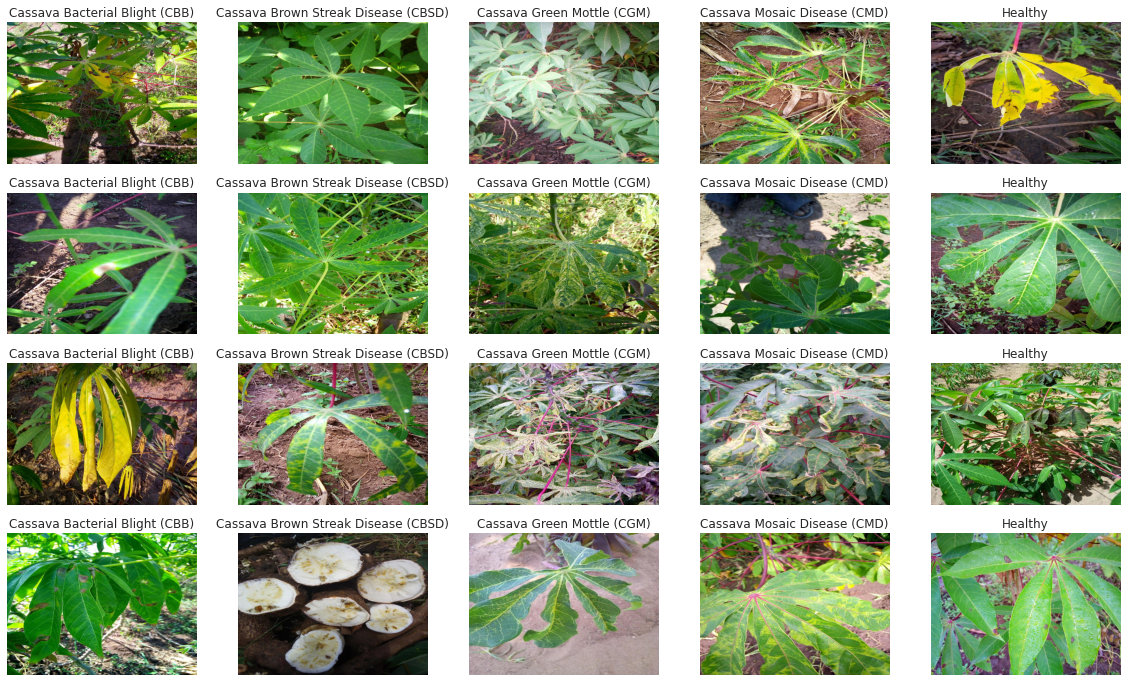

In [23]:
def plot_samples():
    plt.figure(figsize = (20,12))
    for label, group_df in all_df.groupby('label'):
        images = group_df['image_id'].tolist()
        for i in range(4):
            plt.subplot(4, 5, 5 * i + int(label) + 1)
            img = cv2.imread(os.path.join(TRAIN_IMAGES_DIR, images[i]))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.axis('off')
            plt.title(label_to_class[str(label)])
            plt.imshow(img);
plot_samples();

### 4.5. Plot class distribution.

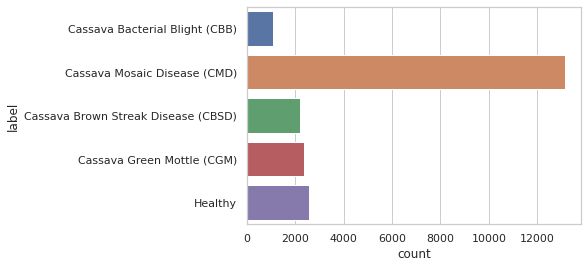

In [24]:
plt.figure(figsize = (6,4))
sns.countplot(y=all_df['label'].astype(str).map(label_to_class), orient='v');

## 5. Feature Engineering

### 5.1. Split dataset for training and validation

Reserving `20%` of data for validation.

For multi class classification we need to use `class_mode="sparse"` in the Keras Image Generators, so, `y_col="label"` column values must be strings.

In [25]:
all_df = all_df.astype({"label": str})

In [26]:
train_df, test_df = train_test_split(all_df, test_size=0.2, stratify=all_df['label'], random_state=seed)

In [27]:
len(train_df), len(test_df)

(17117, 4280)

### 5.2. Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general we should seek to make our input values small. Ideally, we should standardize values to be in the [0, 1].

We will be using a [Keras implementation of EfficientNet](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/) for fine-tuning instead of training the network from scratch. This model takes input images of shape (300, 300, 3), and the input data should range [0, 255]. Normalization is included as part of the model.

## 6. Use a `EfficientNetB3` pre-trained model as our base model

We will be using a [Keras implementation of EfficientNet](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/) for fine-tuning instead of training the network from scratch. This model takes input images of shape (300, 300, 3), and the input data should range [0, 255]. Normalization is included as part of the model.

To use Multi GPU training this method must be invoked under a `tf.distribute.MirroredStrategy` scope.

In [28]:
def create_model() -> tf.keras.Model:
    return tf.keras.Sequential(
        [
            tf.keras.applications.EfficientNetB3(input_shape = (TARGET_HEIGHT, TARGET_WIDTH, 3), 
                                                 include_top = False, 
                                                 weights = 'imagenet'),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(256, activation = 'relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(NUM_CLASSES, activation = 'softmax')
        ]
    )

In [29]:
model = create_model()

43941888/43941136 [==============================] - 1s 0us/step


In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               393472    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 11,178,292
Trainable params: 11,090,989
Non-trainable params: 87,303
_________________________________________________________________


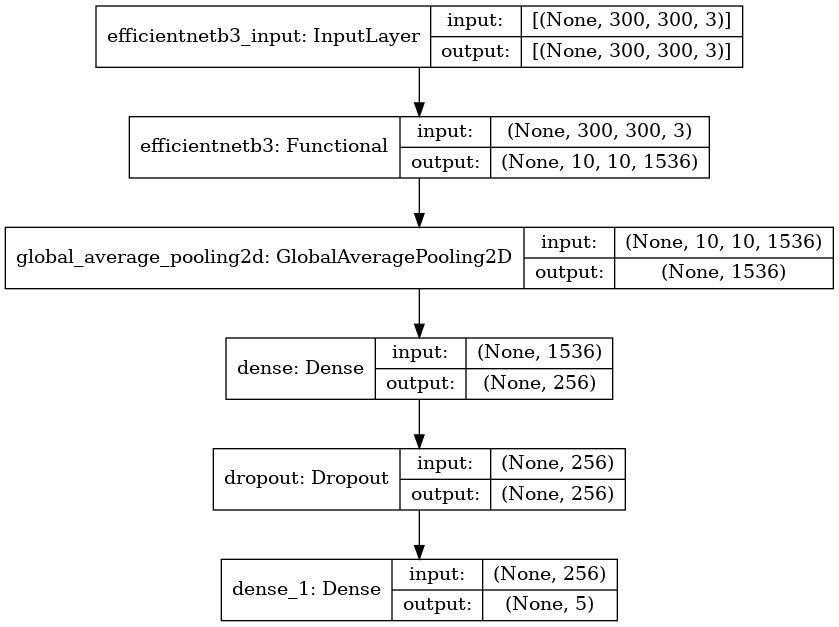

In [31]:
plot_model(model, show_shapes = True)

## 7. Experimenting with different data loading strategies

### 7.1. Create an abstract BaseClassifier
We create a `BaseClassifier` that will encapsulate our common logic and we keep on extending that class to override the `prepare_data` and `train` methods to showcase different data loading strategies and training leveraging that.

In [32]:
class BaseClassifier:
    
    def __init__(self, best_model_path):
        self.best_model_path = best_model_path
        
    def get_compiled_model(self):
        self.model = create_model()
        self.model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                 metrics = ['accuracy'])
        return self.model
    
    def get_callbacks(self):
        # Add Keras Callbacks
        # Stop training when the validation loss metric has stopped decreasing for 5 epochs.
        early_stopping = EarlyStopping(monitor = 'val_loss',
                                       patience = 5,
                                       mode = 'min',
                                       restore_best_weights = True)

        # Save the model with the maximum validation accuracy 
        checkpoint = ModelCheckpoint(self.best_model_path, 
                                     monitor = 'val_accuracy',
                                     verbose = 1,
                                     mode = 'max', 
                                     save_best_only = True)
        # reduce learning rate
        reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                      factor = 0.2,
                                      patience = 2,
                                      min_delta = 0.001, 
                                      mode = 'min',
                                      verbose = 1)
        return [early_stopping, checkpoint, reduce_lr]
    
    def train(self, epochs=1, gpus=[], batch_size=32):
        raise NotImplementedError

In [33]:
def plot_performance(history):
    train_acc = history.history['accuracy']
    valid_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    valid_loss = history.history['val_loss']

    epochs = range(1, len(train_acc) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.set_style("white")
    plt.suptitle('Train history', size = 15)

    ax1.plot(epochs, train_acc, label = "Training Accuracy", color = 'blue')
    ax1.plot(epochs, valid_acc, label = "Validation Accuracy", color = 'red')
    ax1.set_title("Training and Validation Accuracy")
    ax1.legend()

    ax2.plot(epochs, train_loss, label = "Training Loss", color = 'blue')
    ax2.plot(epochs, valid_loss, label = "Validation Loss", color = 'red')
    ax2.set_title("Training and validation Loss")
    ax2.legend()

    plt.show();

### 7.2. Classifier with Keras Image Data Generator
We reserve 20% data for validation and the rest for traininig. Use the Keras [flow_from_dataframe](https://keras.io/api/preprocessing/image/#flowfromdataframe-method) method to generate batches of image (may be augmented) data.
+ `dataframe:` the pandas dataframe which has the list of images.
+ `x_col:` string, column in dataframe that contains the filenames (or absolute paths if directory is None).
+ `y_col:` string or list, column/s in dataframe that has the target data.

**Note:** For multi class classification we need to use `class_mode="sparse"` in the Keras Image Generators, so, `y_col="label"` column values must be strings.

We use `tf.distribute.MirroredStrategy` to create a copy of the model across all devices.

In [34]:
class KerasBasicImageDatagenClassifier(BaseClassifier):

    def __init__(self, best_model_path):
        super().__init__(best_model_path)
        
    def prepare_data(self):
        all_df = pd.read_csv(ROOT_DATA_DIR + 'train.csv')
        all_df['path'] = TRAIN_IMAGES_DIR + all_df.image_id

        all_df = all_df.astype({"label": str})

        # Split dataset for training and validation
        train_df, valid_df = train_test_split(all_df, test_size=0.2, stratify=all_df['label'], random_state=seed)

        traim_im_gen = ImageDataGenerator()

        valid_im_gen = ImageDataGenerator()

        train_data_gen = traim_im_gen.flow_from_dataframe(
            dataframe=train_df,
            directory=TRAIN_IMAGES_DIR,
            x_col="image_id",
            y_col="label",
            target_size=(TARGET_HEIGHT, TARGET_WIDTH),
            class_mode="sparse",
            shuffle=True,
            seed=seed,
            interpolation="nearest")

        valid_data_gen = valid_im_gen.flow_from_dataframe(
            dataframe=valid_df,
            directory=TRAIN_IMAGES_DIR,
            x_col="image_id",
            y_col="label",
            target_size=(TARGET_HEIGHT, TARGET_WIDTH),
            class_mode="sparse",
            shuffle=False,
            seed=seed,
            interpolation="nearest")

        return train_data_gen, valid_data_gen

    def train(self, epochs=1, gpus=[], batch_size=32):
        # Create a MirroredStrategy
        if len(gpus) > 0:
            strategy = tf.distribute.MirroredStrategy(gpus)
        else:
            strategy = tf.distribute.MirroredStrategy()

        available_gpus = len(tf.config.experimental.list_physical_devices('GPU'))
        booked_gpus = strategy.num_replicas_in_sync

        print(f"Training is using {booked_gpus}/{available_gpus} GPUs based on the MirroredStrategy.")

        # scale up batch size due to distributed training
        BATCH_SIZE = strategy.num_replicas_in_sync * batch_size

        # Open a strategy scope and create the model
        with strategy.scope():
            model = self.get_compiled_model()

        train_data_gen, valid_data_gen = self.prepare_data()

        STEP_SIZE_TRAIN = train_data_gen.n // BATCH_SIZE
        STEP_SIZE_VALID = valid_data_gen.n // BATCH_SIZE

        history = model.fit(
            train_data_gen,
            epochs=epochs,
            batch_size=BATCH_SIZE,
            steps_per_epoch=STEP_SIZE_TRAIN,
            validation_data=valid_data_gen,
            validation_steps=STEP_SIZE_VALID,
            callbacks=self.get_callbacks())

        return history

#### 7.2.1. Running with 4 GPUs and Keras Image Data Generator

In [35]:
clf = KerasBasicImageDatagenClassifier(best_model_path='./models/basic_image_datagen_classifier_model.hdf5')

In [36]:
history = clf.train(epochs=10, batch_size=32)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Training is using 4/4 GPUs based on the MirroredStrategy.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',

In [37]:
plot_performance(history)

In [38]:
del clf

### 7.3. Classifier with `Parallelized` Keras Image Data Generator

Can there be a bottleneck? What are the CPUs doing while the GPUs are training? Can we speed up? I felt `Keras ImageDataGenerator` can be tuned. Digging a bit more into the https://keras.io/api/models/model_training_apis/#fit-method documentation reveals that there are `3` parameters which have been rarely discussed on the Kaggle blogs.
+ `max_queue_size`: Integer. Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. If unspecified, max_queue_size will default to 10. The fit_generator will prepare extra data on cpu continuously until the queue is full while GPU working.
+ `workers`: Integer. Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1. If 0, will execute the generator on the main thread.
+ `use_multiprocessing:` Boolean. Used for generator or keras.utils.Sequence input only. If True, use process-based threading. If unspecified, use_multiprocessing will default to False. Note that because this implementation relies on multiprocessing, you should not pass non-picklable arguments to the generator as they can't be passed easily to children processes.

Here, I will be using `max_queue_size=256` and `workers=10` and `use_multiprocessing=False` to bump up the parallelization in the `Keras ImageDataGenerator`. 

We SHOULD NOT USE `use_multiprocessing=True` on `Keras ImageDataGenerator` with `Tensorflow` because that can lead to non-determistic deadlock. I got the following warning messages when I tried to use it.
```
WARNING:tensorflow:Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `tf.data.Dataset`.
WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
```
So, I feel even though I specified `workers=10` it will still use 1 worker since I disabled `use_multiprocessing=False`. I believe only `max_queue_size=256` will be in effect.

This is known issue and is being discussed https://github.com/keras-team/keras-preprocessing/issues/145

In [39]:
class KerasParallelizedImageDatagenClassifier(KerasBasicImageDatagenClassifier):
    
    def train(self, epochs=1, gpus=[], batch_size=32):
        # Create a MirroredStrategy.
        if len(gpus) > 0:
            strategy = tf.distribute.MirroredStrategy(gpus)
        else:
            strategy = tf.distribute.MirroredStrategy()
        
        available_gpus = len(tf.config.experimental.list_physical_devices('GPU'))
        booked_gpus = strategy.num_replicas_in_sync

        print(f"Training is using {booked_gpus}/{available_gpus} GPUs based on the MirroredStrategy.")

        SCALED_BATCH_SIZE = strategy.num_replicas_in_sync * batch_size

        # Open a strategy scope and create the model
        with strategy.scope():
            model = self.get_compiled_model()

        train_data_gen, valid_data_gen = self.prepare_data()
        
        STEP_SIZE_TRAIN = train_data_gen.n//SCALED_BATCH_SIZE
        STEP_SIZE_VALID = valid_data_gen.n//SCALED_BATCH_SIZE

        history = model.fit(
            train_data_gen,
            epochs = epochs,
            batch_size=SCALED_BATCH_SIZE,
            steps_per_epoch = STEP_SIZE_TRAIN,
            validation_data = valid_data_gen,
            validation_steps = STEP_SIZE_VALID,
            callbacks = self.get_callbacks(),
            max_queue_size = 2 * SCALED_BATCH_SIZE, # modified line. Ensure next batch is pre-fetched
            workers=10,
            use_multiprocessing=False) # modified line

        return history

#### 7.3.1. Running with 4 GPUs and Parallelized Keras Image Data Generator

In [40]:
clf = KerasParallelizedImageDatagenClassifier(best_model_path='./models/parallelized_image_datagen_classifier_model.hdf5')

In [41]:
clf.train(epochs=10, batch_size=32)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Training is using 4/4 GPUs based on the MirroredStrategy.
Found 17117 validated image filenames belonging to 5 classes.
Found 4280 validated image filenames belonging to 5 classes.
Epoch 1/10
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1
133/133 [==============================] - 212s 538ms/step - loss: 0.9667 - accuracy: 0.6521 - val_loss: 1.1891 - val_accuracy: 0.7169

Epoch 00001: val_accuracy improved from -inf to 0.71686, saving model to ./models/parallelized_image_datagen_classifier_model.hdf5
Epoch 2/10
133/133 [==============================] - 58s 433ms/step - loss: 0.7291 - accuracy: 0.7455 - val_loss: 0.7413 

In [42]:
del clf

### 7.4. Classifier using TF Dataset from image files Pandas DF

### `tf.data` performance tips

To train a model with this tf dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be added using the `tf.data` API. For more details, see the https://www.tensorflow.org/tutorials/load_data/images guide.


Ref:  
https://sknadig.dev/TensorFlow2.0-dataset/  
https://www.tensorflow.org/tutorials/load_data/images  

When doing distributed training, the efficiency with which you load data can often become critical. Here are a few tips to make sure your `tf.data` pipelines run as fast as possible.

**Note about dataset batching**

**Calling `dataset.batch(batch_size)`**

When creating your dataset, make sure it is batched with the global batch size. For instance, if each of your 8 GPUs is capable of running a batch of 64 samples, you call use a global batch size of 512.

Now, every time we use the dataset object, the generator function is called `batch_size` times. The batch function combines consecutive elements of this dataset into batches. If we reach the end of the dataset and the batch is less than the `batch_size` specified, we can pass the argument `drop_remainder=True` to ignore that particular batch.

**Calling `dataset.cache()`**

If you call `.cache()` on a dataset, its data will be cached after running through the first iteration over the data. Every subsequent iteration will use the cached data. The cache can be in memory (default) or to a local file you specify.

This can improve performance when:

- Your data is not expected to change from iteration to iteration
- You are reading data from a remote distributed filesystem
- You are reading data from local disk, but your data would fit in memory and your workflow is significantly IO-bound (e.g. reading & decoding image files).

**Calling `dataset.shuffle(buffer_size)`**

Here, the argument buffer_size specifies the number of elements from this dataset from which the new dataset will sample. Essentially, this fills the dataset with buffer_size elements, then randomly samples elements from this buffer.

Use `buffer_size>=dataset_size` for perfect shuffling.

**Calling `dataset.prefetch(buffer_size)`**

You should almost always call `.prefetch(buffer_size)` after creating a dataset. It means your data pipeline will run asynchronously from your model, with new samples being preprocessed and stored in a buffer while the current batch
samples are used to train the model. The next batch will be prefetched in GPU memory by the time the current batch is over.

**Calling `dataset.repeat(repeat_count)`**
Here, the dataset is looped over `repeat_count` times. e.g. If we use `repeat(count=2)` we get twice the number of batches for training. If we want to repeat the dataset indefinitely, we should set the argument to count=-1.

#### 7.4.1. Create TF.data.Dataset from Pandas df

We can apply the same principle of splitting the training data into train and validation sets and use `tf.data` to parse the image paths from those sets to create respective `tf.data.Dataset`.

In [43]:
train_df.head()

,image_id,label,path
12650,3267710591.jpg,3,/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_images/3267710591.jpg
16910,4042037111.jpg,2,/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_images/4042037111.jpg
20562,83337985.jpg,3,/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_images/83337985.jpg
2679,1466391339.jpg,2,/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_images/1466391339.jpg
20106,747749936.jpg,3,/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_images/747749936.jpg


In [44]:
train_file_names, val_file_names = list(train_df.path), list(val_df.path)

In [45]:
len(train_file_names), len(val_file_names)

(17117, 4280)

In [46]:
val_file_names[0:10]

['/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_images/3114033989.jpg',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_images/85027801.jpg',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_images/2545699635.jpg',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_images/2082657173.jpg',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_images/3777352797.jpg',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_images/3370579462.jpg',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_images/575135832.jpg',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_images/364372778.jpg',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_images/486370102.jpg',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_images/2849214868.jpg']

#### 7.4.2. Helper functions

In [47]:
## parse from image file path
def parse_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img

In [48]:
# create tf.data.Dataset
train_files_ds = tf.data.Dataset.from_tensor_slices(list(train_df.path))
train_images_ds = train_files_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_labels_ds = tf.data.Dataset.from_tensor_slices(list(train_df.label))
train_ds = tf.data.Dataset.zip((train_images_ds, train_labels_ds))

#### 7.4.3. Running with 4 GPUs and data loaded via tf.data.Dataset

In [49]:
class KerasTFDatasetImageClassifier(BaseClassifier):
    
    def prepare_data(self, batch_size=32, test_size=0.2):
        
        all_df = pd.read_csv(ROOT_DATA_DIR + 'train.csv')
        all_df['path'] = TRAIN_IMAGES_DIR + all_df.image_id

        # using tf.data.Dataset do not require us the labels to the string anymore
        #all_df = all_df.astype({"label": str})

        # Split dataset for training and validation
        train_df, val_df = train_test_split(all_df, test_size=0.2, stratify=all_df['label'], random_state=seed)
        
        train_files_ds = tf.data.Dataset.from_tensor_slices(list(train_df.path))
        train_images_ds = train_files_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        train_labels_ds = tf.data.Dataset.from_tensor_slices(list(train_df.label))
        train_ds = tf.data.Dataset.zip((train_images_ds, train_labels_ds))
        train_ds = train_ds.cache()
        train_ds = train_ds.repeat()
        train_ds = train_ds.shuffle(10000, seed=seed)
        train_ds = train_ds.batch(batch_size)
        train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
        
        val_files_ds = tf.data.Dataset.from_tensor_slices(list(val_df.path))
        val_images_ds = val_files_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        val_labels_ds = tf.data.Dataset.from_tensor_slices(list(val_df.label))
        val_ds = tf.data.Dataset.zip((val_images_ds, val_labels_ds))
        val_ds = val_ds.cache()
        val_ds = val_ds.batch(batch_size)
        val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE)
        
        # number of records
        train_ds_n, val_ds_n = len(train_df), len(val_df)
        
        return train_ds, val_ds, train_ds_n, val_ds_n
    
    def train(self, epochs=1, gpus=[], batch_size=32):
        # Create a MirroredStrategy.
        if len(gpus) > 0:
            strategy = tf.distribute.MirroredStrategy(gpus)
        else:
            strategy = tf.distribute.MirroredStrategy()
        
        available_gpus = len(tf.config.experimental.list_physical_devices('GPU'))
        booked_gpus = strategy.num_replicas_in_sync

        print(f"Training is using {booked_gpus}/{available_gpus} GPUs based on the MirroredStrategy.")

        SCALED_BATCH_SIZE = strategy.num_replicas_in_sync * batch_size

        # Open a strategy scope and create the model
        with strategy.scope():
            model = self.get_compiled_model()

        train_ds, val_ds, train_ds_n, val_ds_n = self.prepare_data()
        
        #STEP_SIZE_TRAIN = train_data_gen.n//SCALED_BATCH_SIZE
        #STEP_SIZE_VALID = valid_data_gen.n//SCALED_BATCH_SIZE
        STEP_SIZE_TRAIN = train_ds_n//SCALED_BATCH_SIZE # len(train_df) == 17117
        STEP_SIZE_VALID = val_ds_n//SCALED_BATCH_SIZE  # len(val_df) == 4280

        history = model.fit(
            train_ds,
            epochs = epochs,
            batch_size=SCALED_BATCH_SIZE,
            steps_per_epoch = STEP_SIZE_TRAIN,
            validation_data = val_ds,
            validation_steps = STEP_SIZE_VALID,
            callbacks = self.get_callbacks())

        return history

In [50]:
clf = KerasTFDatasetImageClassifier(best_model_path='./models/image_tfds_classifier_model.hdf5')

In [51]:
clf.train(epochs=10, batch_size=32)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Training is using 4/4 GPUs based on the MirroredStrategy.
Epoch 1/10
133/133 [==============================] - 218s 530ms/step - loss: 0.9586 - accuracy: 0.6642 - val_loss: 1.6124 - val_accuracy: 0.1108

Epoch 00001: val_accuracy improved from -inf to 0.11080, saving model to ./models/image_tfds_classifier_model.hdf5
Epoch 2/10
133/133 [==============================] - 56s 422ms/step - loss: 0.7292 - accuracy: 0.7401 - val_loss: 2.4296 - val_accuracy: 0.1108

Epoch 00002: val_accuracy did not improve from 0.11080
Epoch 3/10
133/133 [==============================] - 54s 409ms/step - loss: 0.7019 - accuracy: 0.7678 - val_loss: 3.4125 - val_accuracy: 0.1108

Epoch 00003: val_accuracy did not improve from 0.11080

Epoch 00003: ReduceLROnPlateau r

In [52]:
del clf

### 7.5. Classifier using TF Dataset from TFRecords

The competition provided additional tfrecords files which are already partitioned into 15 partitioned files. We will load the partitions across the replicas. We will still apply the similar split of reserving 20% for validation and the rest for training.

**Cons:** Unfortunately we cannot split by stratifying based on the labels here.

In [53]:
TRAIN_TFREC_DIR

'/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_tfrecords/'

In [54]:
!ls {TRAIN_TFREC_DIR}

ld_train00-1338.tfrec  ld_train06-1338.tfrec  ld_train12-1338.tfrec
ld_train01-1338.tfrec  ld_train07-1338.tfrec  ld_train13-1338.tfrec
ld_train02-1338.tfrec  ld_train08-1338.tfrec  ld_train14-1338.tfrec
ld_train03-1338.tfrec  ld_train09-1338.tfrec  ld_train15-1327.tfrec
ld_train04-1338.tfrec  ld_train10-1338.tfrec
ld_train05-1338.tfrec  ld_train11-1338.tfrec


In [55]:
file_names = tf.io.gfile.glob(TRAIN_TFREC_DIR + '*.tfrec')
file_names

['/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_tfrecords/ld_train05-1338.tfrec',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_tfrecords/ld_train14-1338.tfrec',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_tfrecords/ld_train09-1338.tfrec',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_tfrecords/ld_train10-1338.tfrec',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_tfrecords/ld_train01-1338.tfrec',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_tfrecords/ld_train07-1338.tfrec',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_tfrecords/ld_train12-1338.tfrec',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_tfrecords/ld_train03-1338.tfrec',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_tfrecords/ld_train06-1338.tfrec',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classifica

In [56]:
train_file_names, val_file_names = train_test_split(tf.io.gfile.glob(TRAIN_TFREC_DIR + '*.tfrec'), test_size=0.2, random_state=seed)

In [57]:
train_file_names

['/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_tfrecords/ld_train01-1338.tfrec',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_tfrecords/ld_train07-1338.tfrec',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_tfrecords/ld_train11-1338.tfrec',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_tfrecords/ld_train08-1338.tfrec',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_tfrecords/ld_train13-1338.tfrec',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_tfrecords/ld_train03-1338.tfrec',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_tfrecords/ld_train04-1338.tfrec',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_tfrecords/ld_train15-1327.tfrec',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_tfrecords/ld_train02-1338.tfrec',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classifica

In [58]:
val_file_names

['/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_tfrecords/ld_train05-1338.tfrec',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_tfrecords/ld_train00-1338.tfrec',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_tfrecords/ld_train09-1338.tfrec',
 '/mnt/user-home/kaggle/cassava-leaf-disease-classification/data/train_tfrecords/ld_train14-1338.tfrec']

#### 7.5.1. Helper functions

**Helper functions** for parsing and loading data from https://www.tensorflow.org/tutorials/load_data/tfrecord.

#### 7.5.2. Running with 4 GPUs and data loaded from TFRecord

In [59]:
from functools import partial

def decode_image(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def read_tfrecord(example, labeled):
    if labeled:
        tfrecord_format = {
            'image': tf.io.FixedLenFeature([], tf.string),
            'target': tf.io.FixedLenFeature([], tf.int64)
        }
    else:
        tfrecord_format = {
            'image': tf.io.FixedLenFeature([], tf.string),
            'image_name': tf.io.FixedLenFeature([], tf.string)
        }

    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])

    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label

    idnum = example['image_name']
    return image, idnum

def load_dataset(filenames, labeled=True, ordered=False):
    # Creating option for tf.data.Dataset
    ignore_order = tf.data.Options()

    if not ordered:
        # The outputs produced will not be in deterministic order
        # default is True
        ignore_order.experimental_deterministic = False

    # Creating dataset using multiple TFRecord files and with AUTOTUNE
    # it'll use all the processes for transformation
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE)

    # Using data as soon as it streams in, rather than in its original order
    # if the ordered=False
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(
        partial(read_tfrecord, labeled=labeled),
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )    
    return dataset

In [60]:
class KerasTFRecordsImageClassifier(BaseClassifier):
    
    def prepare_data(self, batch_size=32, test_size=0.2):
        
        # Split dataset for training and validation
        train_file_names, val_file_names = train_test_split(tf.io.gfile.glob(TRAIN_TFREC_DIR + '*.tfrec'), test_size=0.2, random_state=seed)
    
        train_ds = load_dataset(train_file_names)
        train_ds = train_ds.cache()
        train_ds = train_ds.repeat()
        train_ds = train_ds.shuffle(10000, seed=seed)
        train_ds = train_ds.batch(batch_size)
        train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
        
        val_ds = load_dataset(val_file_names)
        val_ds = val_ds.cache()
        val_ds = val_ds.batch(batch_size)
        val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE)
        
        return train_ds, val_ds
    
    def train(self, epochs=1, gpus=[], batch_size=32):
        # Create a MirroredStrategy.
        if len(gpus) > 0:
            strategy = tf.distribute.MirroredStrategy(gpus)
        else:
            strategy = tf.distribute.MirroredStrategy()
        
        available_gpus = len(tf.config.experimental.list_physical_devices('GPU'))
        booked_gpus = strategy.num_replicas_in_sync

        print(f"Training is using {booked_gpus}/{available_gpus} GPUs based on the MirroredStrategy.")

        SCALED_BATCH_SIZE = strategy.num_replicas_in_sync * batch_size

        # Open a strategy scope and create the model
        with strategy.scope():
            model = self.get_compiled_model()

        train_ds, valid_ds = self.prepare_data()
        
        #STEP_SIZE_TRAIN = train_data_gen.n//SCALED_BATCH_SIZE
        #STEP_SIZE_VALID = valid_data_gen.n//SCALED_BATCH_SIZE
        STEP_SIZE_TRAIN = 17117//SCALED_BATCH_SIZE # len(train_df) == 17117
        STEP_SIZE_VALID = 4280//SCALED_BATCH_SIZE  # len(val_df) == 4280

        history = model.fit(
            train_ds,
            epochs = epochs,
            batch_size=SCALED_BATCH_SIZE,
            steps_per_epoch = STEP_SIZE_TRAIN,
            validation_data = valid_ds,
            validation_steps = STEP_SIZE_VALID,
            callbacks = self.get_callbacks())

        return history

In [61]:
clf = KerasTFRecordsImageClassifier(best_model_path='./models/image_tfrec_classifier_model.hdf5')

In [62]:
clf.train(epochs=10, batch_size=32)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Training is using 4/4 GPUs based on the MirroredStrategy.
Epoch 1/10
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1
133/133 [==============================] - 227s 517ms/step - loss: 0.9741 - accuracy: 0.6448 - val_loss: 2.2793 - val_accuracy: 0.1155

Epoch 00001: val_accuracy improved from -inf to 0.11553, saving model to ./models/image_tfrec_classifier_model.hdf5
Epoch 2/10
133/133 [==============================] - 56s 418ms/step - loss: 0.6502 - accuracy: 0.7746 - val_loss: 2.4844 - val_accuracy: 0.1174

Epoch 00002: val_accuracy improved from 0.11553 to 0.11742, saving model to ./models/image_tfrec_classifier_model.

In [63]:
del clf

## 8. Experimenting with different Image Augmentation strategies

### 8.1. Image Augmentation with ImageDataGenerator 

We reserve 20% data for validation and the rest for traininig. Use the Keras [flow_from_dataframe](https://keras.io/api/preprocessing/image/#flowfromdataframe-method) method to generate batches of **augmented**  data.
+ `dataframe:` the pandas dataframe which has the list of images.
+ `x_col:` string, column in dataframe that contains the filenames (or absolute paths if directory is None).
+ `y_col:` string or list, column/s in dataframe that has the target data.

**Note:** For multi class classification we need to use `class_mode="sparse"` in the Keras Image Generators, so, `y_col="label"` column values must be strings.

We use `tf.distribute.MirroredStrategy` to create a copy of the model across all devices.

#### 8.1.1.. Running with 4 GPUs and images augemented by Keras Image Data Generator

In [64]:
class KerasAugmentedImageDatagenClassifier(KerasBasicImageDatagenClassifier):

    def prepare_data(self):
        all_df = pd.read_csv(ROOT_DATA_DIR + 'train.csv')
        all_df['path'] = TRAIN_IMAGES_DIR + all_df.image_id

        all_df = all_df.astype({"label": str})

        # Split dataset for training and validation
        train_df, valid_df = train_test_split(all_df, test_size=0.2, stratify=all_df['label'], random_state=seed)

        traim_im_gen = ImageDataGenerator(
            rotation_range = 30,
            # width_shift_range = 0.2,
            # height_shift_range = 0.2,
            # shear_range = 0.2,
            zoom_range = 0.2,
            # brightness_range = [0.5,1.5],
            horizontal_flip = True,
            vertical_flip = True,
            fill_mode = 'nearest'
        )

        valid_im_gen = ImageDataGenerator()

        train_data_gen = traim_im_gen.flow_from_dataframe(
            dataframe=train_df,
            directory=TRAIN_IMAGES_DIR,
            x_col="image_id",
            y_col="label",
            target_size=(TARGET_HEIGHT, TARGET_WIDTH),
            class_mode="sparse",
            shuffle=True,
            seed=seed,
            interpolation="nearest")

        valid_data_gen = valid_im_gen.flow_from_dataframe(
            dataframe=valid_df,
            directory=TRAIN_IMAGES_DIR,
            x_col="image_id",
            y_col="label",
            target_size=(TARGET_HEIGHT, TARGET_WIDTH),
            class_mode="sparse",
            shuffle=False,
            seed=seed,
            interpolation="nearest")

        return train_data_gen, valid_data_gen

In [65]:
clf = KerasAugmentedImageDatagenClassifier(best_model_path='./models/aug_image_datagen_classifier_model.hdf5')

In [66]:
clf.train(epochs=10, batch_size=32)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Training is using 4/4 GPUs based on the MirroredStrategy.
Found 17117 validated image filenames belonging to 5 classes.
Found 4280 validated image filenames belonging to 5 classes.
Epoch 1/10
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1
133/133 [==============================] - 316s 1s/step - loss: 1.0175 - accuracy: 0.6370 - val_loss: 1.3415 - val_accuracy: 0.7348

Epoch 00001: val_accuracy improved from -inf to 0.73485, saving model to ./models/aug_image_datagen_classifier_model.hdf5
Epoch 2/10
133/133 [==============================] - 148s 1s/step - loss: 0.7968 - accuracy: 0.7149 - val_loss: 1.1780 - val_accuracy

In [67]:
del clf

### 8.2. Pushing Image Augmentation to the Model

We can implement data augmentation using the layers from `tf.keras.layers.experimental.preprocessing`. These can be included inside your model like other layers, and run on the GPU.

It has two benefits:
+ Image augmentation being part  of the Model we do not need a separete pre-processing step in the pipeline
+ GPU computation can be leveraged to speed up the augementation

In [68]:
def create_augmented_model() -> tf.keras.Model:    
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(TARGET_HEIGHT, TARGET_WIDTH, 3)),
        
        tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.RandomCrop(height=TARGET_HEIGHT, width=TARGET_WIDTH),
            tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.experimental.preprocessing.RandomRotation(0.25),
            tf.keras.layers.experimental.preprocessing.RandomZoom((-0.2, 0)),
            tf.keras.layers.experimental.preprocessing.RandomContrast((0.2,0.2))
        ]),
        
        tf.keras.applications.EfficientNetB3(input_shape=(TARGET_HEIGHT, TARGET_WIDTH, 3), 
                                                        include_top=False, 
                                                        weights='imagenet'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
    ])

#### 8.2.1. Running with 4 GPUs and images augemented by `tf.keras.layers.experimental.preprocessing` layers

In [69]:
model = create_augmented_model()

In [70]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 300, 300, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1536)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               393472    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 1285      
Total params: 11,178,292
Trainable params: 11,090,989
Non-trainable params: 87,303
_____________________________________

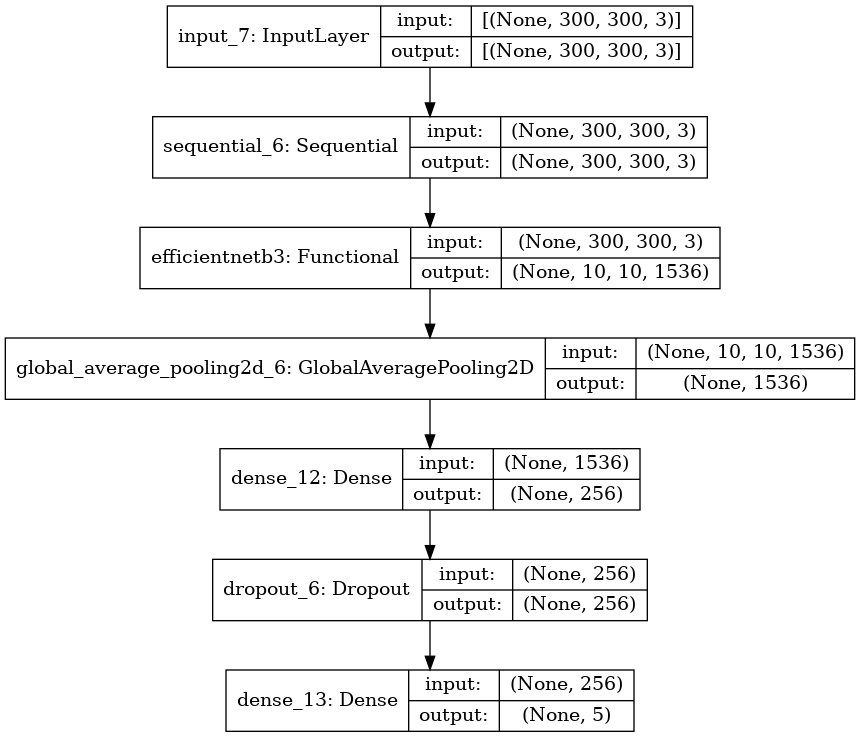

In [71]:
plot_model(model, show_shapes = True)

In [72]:
class KerasAugmentedModelClassifier(KerasBasicImageDatagenClassifier):
    
    def get_compiled_model(self):
        self.model = create_augmented_model()
        self.model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                 metrics = ['accuracy'])
        return self.model

In [73]:
clf = KerasAugmentedModelClassifier(best_model_path='./models/aug_model_classifier_model.hdf5')

In [74]:
clf.train(epochs=10, batch_size=32)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Training is using 4/4 GPUs based on the MirroredStrategy.
Found 17117 validated image filenames belonging to 5 classes.
Found 4280 validated image filenames belonging to 5 classes.
Epoch 1/10
133/133 [==============================] - 239s 636ms/step - loss: 0.9768 - accuracy: 0.6583 - val_loss: 1.3780 - val_accuracy: 0.6297

Epoch 00001: val_accuracy improved from -inf to 0.62973, saving model to ./models/aug_model_classifier_model.hdf5
Epoch 2/10
133/133 [==============================] - 73s 546ms/step - loss: 0.7563 - accuracy: 0.7304 - val_loss: 0.6633 - val_accuracy: 0.7614

Epoch 00002: val_accuracy improved from 0.62973 to 0.76136, saving model to ./models/aug_model_classifier_model.hdf5
Epoch 3/10
133/133 [==============================

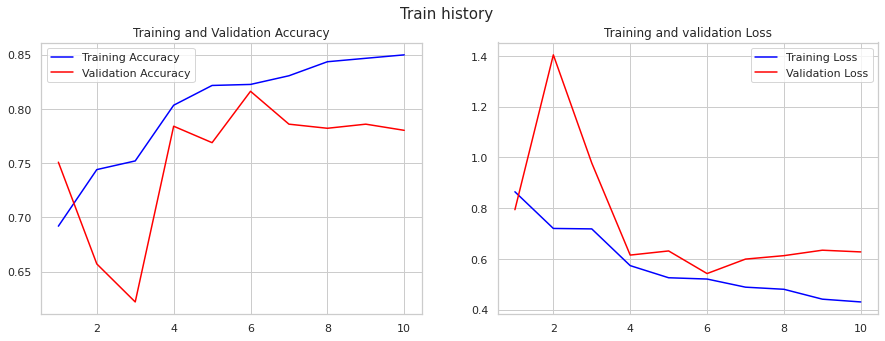

In [75]:
plot_performance(history)

In [76]:
del clf

### 8.3. Adding Image Augmentation to the TFRecord load

The `tf.data` API of Tensorflow is a great way to build a pipeline for sending data to the GPU. Setting up data augmentation can be a bit tricky though since you may not have exact equivalence of some transformation such as zoom.

Ref: https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/

In [77]:
# Data Augmentation - https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/
def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO) statement in the following function this happens essentially for free on TPU. 
    # Data pipeline code is executed on the "CPU" part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_crop(image, (TARGET_HEIGHT, TARGET_WIDTH, 3))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=1, dtype=tf.int32))
    image = tf.image.random_contrast(image,0.1,0.2)
    # no straightforward random zoom available
    return image, label

#### 8.3.1. Running with 4 GPUs and augmenting TFRecord dataset with a data_augment function

In [78]:
class KerasAugmentedTFRecordsImageClassifier(KerasTFRecordsImageClassifier):
    
    def prepare_data(self, batch_size=32, test_size=0.2):
        
        # Split dataset for training and validation
        train_file_names, val_file_names = train_test_split(tf.io.gfile.glob(TRAIN_TFREC_DIR + '*.tfrec'), test_size=0.2, random_state=seed)
    
        train_ds = load_dataset(train_file_names)
        train_ds = train_ds.map(data_augment, tf.data.experimental.AUTOTUNE) # adding augmentation 
        train_ds = train_ds.cache()
        train_ds = train_ds.repeat()
        train_ds = train_ds.shuffle(10000, seed=seed)
        train_ds = train_ds.batch(batch_size)
        train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
        
        val_ds = load_dataset(val_file_names)
        val_ds = val_ds.cache()
        val_ds = val_ds.batch(batch_size)
        val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE)
        
        return train_ds, val_ds

In [79]:
clf = KerasAugmentedTFRecordsImageClassifier(best_model_path='./models/aug_tfrecords_classifier_model.hdf5')

In [80]:
history = clf.train(epochs=10, batch_size=32)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Training is using 4/4 GPUs based on the MirroredStrategy.
Epoch 1/10
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1
133/133 [==============================] - 230s 527ms/step - loss: 1.0746 - accuracy: 0.6303 - val_loss: 1.2619 - val_accuracy: 0.6155

Epoch 00001: val_accuracy improved from -inf to 0.61553, saving model to ./models/aug_tfrecords_classifier_model.hdf5
Epoch 2/10
133/133 [==============================] - 56s 425ms/step - loss: 0.8287 - accuracy: 0.7105 - val_loss: 3.2527 - val_accuracy: 0.1165

Epoch 00002: val_accuracy did not improve from 0.61553
Epoch 3/10
133/133 [==============================] - 55s

In [81]:
del clf

## 9. Suggestions

Here, I put forth some suggestions that one can add.

+ create custom TF Records by stratifying, shuffling and augmenting the dataset first and just load them during training as td.data.Dataset.

**References:**

Some of the articles without which this notebook would have not been at all possible:

+ [1] https://www.tensorflow.org/guide/gpu
+ [2] https://www.tensorflow.org/api_docs/python/tf/distribute/MirroredStrategy
+ [3] https://www.tensorflow.org/tutorials/load_data/images
+ [4] https://www.tensorflow.org/api_docs/python/tf/data/Dataset
+ [5] https://sknadig.dev/TensorFlow2.0-dataset/
+ [6] https://www.tensorflow.org/tutorials/load_data/tfrecord
+ [7] https://keras.io/api/models/model_training_apis/#fit-method
+ [8] https://keras.io/api/preprocessing/image/
+ [9] https://www.tensorflow.org/addons/tutorials/image_ops
+ [10] https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/
+ [11] https://www.kaggle.com/lavanyask/cassava-leaf-disease-starter-notebook
+ [12] https://www.kaggle.com/maksymshkliarevskyi/cassava-leaf-disease-best-keras-cnn
+ [13] https://www.kaggle.com/jessemostipak/getting-started-tpus-cassava-leaf-disease
+ [14] https://www.kaggle.com/xhlulu/cassava-train-efficientnet-on-tpu-in-100-lines